<a href="https://colab.research.google.com/github/IgorFesenko/prokariotic_smORFs/blob/main/ismORFs_resource.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of prokaryotic intergenic small ORFs**

Microproteins encoded by small open reading frames (smORFs) comprise the “dark matter” of proteomes. In this comprehensive study of intergenic smORFs (ismORFs, 15–70 codons) in 5,668 bacterial genomes of the family Enterobacteriaceae, we identified 67,297 clusters of ismORFs subject to purifying selection. We compiled a catalog of predicted microprotein families with different levels of evidence from synteny analysis, structure prediction, and transcription and translation data. This study offers a resource for investigation of biological functions of microproteins.


# **Introduction**

This Jupiter notebook is a supplemental material of the paper ***The Hidden Bacterial Microproteome*** ([link here](https://www.biorxiv.org/content/10.1101/2024.02.17.580829v1.full)) and we encourage you to read it before using this analysis. The goal of this notebook is to get the opportunity to find and analyze ismORFs identified in our study.

 **To start the notebook, perform Runtime -> Run all**

If you want to save data to your PC, use **download_table** checkbox



***The notebook contains five main parts:***

- Extract all ismORFs from the selected genome or species

- Extracting the list of ismORFs from the selected region in a genome

- Getting info about ismORF (need to know ismORF id)

- Search for possible homologs in our set of ismORFs (jackhammer)

- Exploring predicted structures of identified ismORFs

In [3]:
#@title Load data and import modules (once before analysis)
#@markdown This might take a few minutes
%%capture

!rm -r /content/*
!pip install pygenomeviz biopython pymsaviz &
!wget -q -o content ftp.ncbi.nlm.nih.gov/pub/fesenko/ENTERO67K_MAFFT_CLSTR.tar.gz
!wget -q -o content ftp.ncbi.nlm.nih.gov/pub/fesenko/ENTERO67_ALLINFOshort.parquet
!wget -q -o content ftp.ncbi.nlm.nih.gov/pub/fesenko/entero67gff.tar.gz
!tar -xzf entero67gff.tar.gz &
!tar -xzf ENTERO67K_MAFFT_CLSTR.tar.gz &
!rm /content/entero67gff.tar.gz &


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pymsaviz import MsaViz, get_msa_testdata
from pygenomeviz import GenomeViz
from pygenomeviz.parser import Gff
from google.colab import files


class Description:

    ### Class shows info about ismORF ####

    # Dataframe with data
    def __init__(self, df):
        self.table = df
        self.name = False
        self.represent = ['NZ_AP022547.1', 'NC_003197.2', 'NC_004337.2','NZ_CP029205.1',
                 'NZ_CP019986.1', 'NZ_CP027107.1', 'NZ_CP023706.1', 'NZ_AP019630.1',
                 'NC_013961.1', 'NC_000913.3', 'NZ_CP016337.1', 'NZ_CP013990.1',
                 'NZ_CP077366.1', 'NC_010554.1', 'NC_014500.1', 'NZ_CP050150.1',
                 'NZ_LR699007.1', 'NZ_CP051652.1', 'NZ_CP023536.1', 'NZ_CP041247.1',
                 'NZ_CP072199.1', 'NZ_CP009792.1']


    @property
    def info(self):
      try:
        if self.name:
            print(f"Genus: {self.genus}\nStrain: {self.strain}\nGenome: {self.genome}\nSequence: {self.seq}\nLength: {self.len}aa\nTransmembrane domain:{self.tm}\nStart: {self.start} End: {self.end} Strand: {self.strand}\n\n")
            print(f"Cluster ID: {self.clstr}\nCluster size:{self.size}\nIntergenus clusters: {self.cons_clstr_view}\nSynteny: {self.synten}\n")
            print(f"Transcription(TPM): {self.tpm}\nRibo start: {self.ribotis}\nRibo signal: {self.riborpf}\n")
            #print(f"Evolutionary rates:\n{self.evol.head()}")
      except:
        print("ismORF did not find")

    @info.setter
    def info(self, name):
        self.name = name
        res_entero = self.table[self.table['id']==self.name]
        if len(res_entero) == 0:
          self.name = False
          print("ismORF did not find")
          return None

        # info
        self.clstr = res_entero['Cluster_ID'].values[0]
        self.seq = str(res_entero['Sequence'].values[0])
        self.genome = str(res_entero['Genome'].values[0])
        self.genus = str(res_entero['Genus'].values[0])
        self.len = len(self.seq)
        self.size = int(self.table[self.table['Cluster_ID']==self.clstr]['id'].nunique())
        self.strain = str(res_entero['Strain'].values[0])
        self.tm = str(res_entero['TM'].values[0])

        # position
        self.start = int(res_entero['start'].values[0])
        self.end = int(res_entero['end'].values[0])
        self.strand = str(res_entero['strand'].values[0])

        # conservation
        try:
            self.synten = ";".join(set(res_entero['LCB_ID']))
            self.synten = 'Yes'
        except:
            self.synten = 'not found'
        try:
            self.cons_clstr = res_entero['HomologClusters'].values[0].split(';')
            self.cons_clstr_view = ', '.join(self.cons_clstr)
        except:
            self.cons_clstr = ['not found']
            self.cons_clstr_view = 'not found'
        #transcription
        try:
            self.tpm = np.round(res_entero['TPM'].values[0],2)
        except:
            self.tpm = 'no'
        #Ribo-seq
        self.ribotis = str(res_entero['TIScounts'].values[0])
        self.riborpf = str(res_entero['RPFcounts'].values[0])

        #evoluton
        #self.evol = res_entero[['dN', 'dS', 'dN/dS', 'Kd']]

    def fasta(self):
        # print reduplicated sequences in references and representatives genomes
        self.clusters = []
        self.clusters.extend(self.clstr)
        self.clusters.extend(self.cons_clstr)
        result = []
        result.append((f"{self.genus}_{self.name}",self.genome, self.seq))

        fasta_res = self.table[self.table['Cluster_ID'].isin(self.cons_clstr)]
        #print(fasta_res.shape)

        fasta_res = fasta_res[fasta_res['Genome'].isin(self.represent)]

        try:
            for index, row in fasta_res.iterrows():
                result.append((f"{row['Genus']}_{row['id']}",str(row['Genome']),str(row['Sequence'])))
        except:
            pass

        print()
        fasta_df = pd.DataFrame(data=result, columns=['id','Genome', 'Sequence'])
        fasta_df = fasta_df.drop_duplicates(subset='Genome')
        for index,desc in fasta_df.iterrows():
            print(f">{desc['id']}\n{desc['Sequence']}")

    def allfasta(self):
        print(f"Cluster_ID: {self.clstr}")
        msa_file = f"/content/ENTERO67K_MAFFT_CLSTR/{self.clstr}.nonredund.mafft"
        mv = MsaViz(msa_file, wrap_length=80, show_count=True, show_consensus=True, color_scheme="Clustal", show_label=False)
        #mv.savefig("api_example01.png")
        fig = mv.plotfig()
        return self.clstr


    def visualisation(self, up=10000, down=10000, save=True):
        # visualisation of chromosome region with ismORF
        if self.name:
          start = self.end - down # lower limit for locus
          end = self.start + up # upper limit for locus

          gff_file = f"/content/entero67GFF/{self.genome}.gff.gz"
          gff = Gff(gff_file)
          smorf_strand = int(f"{self.strand}1")
          print(f"Range: {start}:{end}")

          gv = GenomeViz()
          gv.set_scale_bar(ymargin=0.5)

          target_ranges = ((start, end))
          track = gv.add_feature_track(name=f"Genome: {gff.name}", segments=target_ranges, labelsize=20)

          cds_features = gff.extract_features(feature_type="CDS", target_range=target_ranges)
          rrna_features = gff.extract_features(feature_type="rRNA", target_range=target_ranges)
          nrna_features = gff.extract_features(feature_type="ncRNA", target_range=target_ranges)

          track.add_features(cds_features,label_type="gene", fc="skyblue", lw=1.5, text_kws=dict(rotation=45, size=30))
          track.add_features(rrna_features, label_type="product", fc="lime", hatch="//",lw=1.5, text_kws=dict(rotation=45, size=30))
          track.add_features(nrna_features, label_type="product", fc="limegreen", lw=1.5, hatch="||",text_kws=dict(rotation=45, size=30))


          track.add_sublabel(f"{self.genus}\n{end - start} bp", ymargin=1.0,size=20, color="black")
          track.add_feature(start=self.start, end=self.end, strand=smorf_strand, plotstyle="bigarrow", label=self.name, facecolor="red", edgecolor="black", linewidth=1, text_kws=dict(rotation=45, size=20))
          fig = gv.plotfig()
          if save:
            fig.savefig(f"content/{self.name}.jpeg", dpi=300)
          else:
            print()
            return None


table = pd.read_parquet(r'/content/ENTERO67_ALLINFOshort.parquet')
ismorf = Description(table)

In [ ]:
#@title **EXTRACT ALL ismORFs FROM THE SELECTED GENOME**
#@markdown Click in the "Run" button to get a table
download_table = False #@param {type:"boolean"}
#@markdown Use "download_table" checkbox to save the table to your PC

#@markdown **Type genome id to get a list of ismORFs**
genome_id = "NC_000913.3" #@param {type:"string"}

res_table = table[table['Genome']==genome_id]
print(f"\033[1m Strain: \033[0;0m {res_table['Strain'].unique()[0]}\n")
if len(res_table)>0:
  print(res_table[['Genus', 'start', 'end', 'strand', 'id']].head())
  res_table.to_csv(f"/content/{genome_id}_ismORFs.csv", index=False)
  print("."*20)
  print("."*20)
  if download_table:
    res_table.to_csv(f"/content/{genome_id}_ismORFs.csv", index=False)
    files.download(f'/content/{genome_id}_ismORFs.csv')
else:
  print("Species did not find")


 Strain:  Escherichia_coli_K-12_sub_MG1655

              Genus   start     end strand                   id
212276  Escherichia   20628   20685      +   NC_000913.3_ORF.55
212277  Escherichia  111474  111546      +  NC_000913.3_ORF.389
212278  Escherichia  138681  138729      +  NC_000913.3_ORF.475
212279  Escherichia  149625  149676      +  NC_000913.3_ORF.504
212280  Escherichia  214125  214182      +  NC_000913.3_ORF.786
....................
....................


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If you do not know how to find genome id, use NCBI ([link here](https://www.ncbi.nlm.nih.gov/))

In [ ]:
#@markdown **If do not know genome id, type the species name**
#genus = "Escherichia" #@param {type:"string"}
species = "Escherichia coli" #@param {type:"string"}
res_table = table[table['Species']==species]
download_table = False #@param {type:"boolean"}
#@markdown Use "download_table" checkbox to save the table to your PC
if len(res_table)>0:
  print(res_table[['Genus', 'start', 'end', 'strand', 'id']].head(), '...')
  print("."*20)
  print("."*20)
  if download_table:
    res_table.to_csv(f"/content/{species}_ismORFs.csv.zip", index=False, compression='zip')
    files.download(f'/content/{species}_ismORFs.csv.zip')
else:
  print("Species did not find")


              Genus   start     end strand                   id
209989  Escherichia  145359  145407      +   CP011113.2_ORF.556
209990  Escherichia  161121  161184      +   CP011113.2_ORF.618
209991  Escherichia  258273  258327      +   CP011113.2_ORF.933
209992  Escherichia  259920  259998      +   CP011113.2_ORF.941
209993  Escherichia  307284  307332      +  CP011113.2_ORF.1163 ...
....................
....................


You will able to find the species of your interest using table that were saved to PC and extract the corresponding genome id

If you do not know where to find genome id, use NCBI ([link here](https://www.ncbi.nlm.nih.gov/))

  ismORFs in this region: 

----------
                            id    start      end                    Sequence
212612   NC_000913.3_ORF.88154  4583135  4583213  LAALVHPGHVLLYAPGDSLTCRLDAT
2375523  NC_000913.3_ORF.17415  4580004  4580061         VGYDWREIIKSAPERCARK
2375577  NC_000913.3_ORF.34913  4579969  4580026         MGNFWNDLNIFMWVMIGVK ...
....................
....................
Range: 4577569:4587026


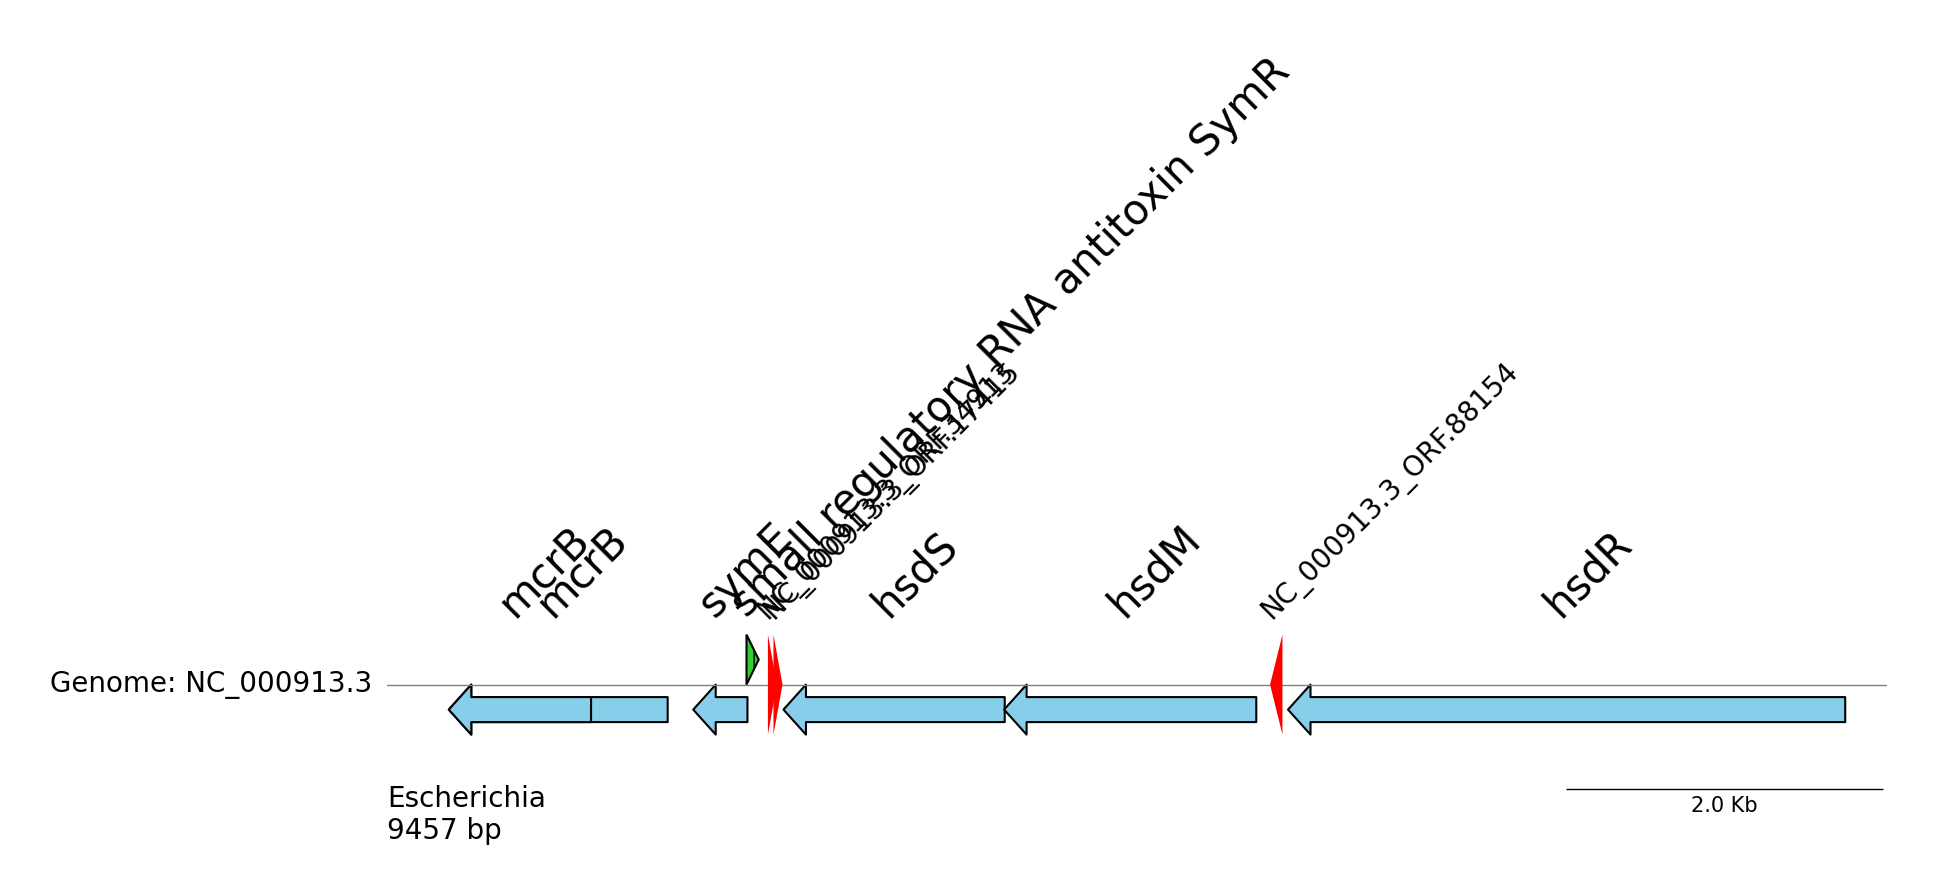

In [13]:
#@title **EXTRACT ismORFs FROM GENOME REGION**
#@markdown Click in the "Run" button to get ismORFs from genome region

class Region:

    # Dataframe with data
    def __init__(self, df, start, end, genome):
        self.table = df[df['Genome']==genome]
        self.start = start
        self.end = end
        self.genome = genome
        self.genus = self.table['Genus'].values[0]

    def ismorfs(self):
        self.res = self.table[self.table['start']>=self.start]
        self.res = self.res[self.res['end']<=self.end]
        print(f" \033[1m ismORFs in this region: \033[0;0m")
        print()
        #print(self.res[['id','start', 'end', 'strand', 'Sequence', 'Genus', 'Cluster_ID']])
        print("-"*10)
        #print("Table with ismORFs saved in ismORFs.csv")
        return self.res
        #self.res.to_csv(r'/content/ismORFs.csv', index=False)


    def visualisation(self):
        gff_file = f"/content/entero67GFF/{self.genome}.gff.gz"
        gff = Gff(gff_file)
        print(f"Range: {self.start}:{self.end}")
        gv = GenomeViz()
        gv.set_scale_bar(ymargin=0.5)

        target_ranges = ((self.start, self.end))
        track = gv.add_feature_track(name=f"Genome: {gff.name}", segments=target_ranges, labelsize=20)


        #track.add_gff_features(gff, feature_type="CDS", facecolor="skyblue", linewidth=0.5, label_type="gene", labelvpos="top", labelsize=30)
        cds_features = gff.extract_features(feature_type="CDS", target_range=target_ranges)
        rrna_features = gff.extract_features(feature_type="rRNA", target_range=target_ranges)
        nrna_features = gff.extract_features(feature_type="ncRNA", target_range=target_ranges)

        track.add_features(cds_features,label_type="gene", fc="skyblue", lw=1.5, text_kws=dict(rotation=45, size=30))
        track.add_features(rrna_features, label_type="product", fc="lime", hatch="//",lw=1.5, text_kws=dict(rotation=45, size=30))
        track.add_features(nrna_features, label_type="product", fc="limegreen", lw=1.5, hatch="||",text_kws=dict(rotation=45, size=30))
        track.add_sublabel(f"{self.genus}\n{self.end - self.start} bp", ymargin=1.0,size=20, color="black")
        # draw microproteins
        for index, row in self.res.iterrows():
            smorf_start = int(row['start'])
            smorf_end = int(row['end'])
            smorf_strand = int(f"{row['strand']}1")
            smorf_name = str(row['id'])
            track.add_feature(start=smorf_start, end=smorf_end, strand=smorf_strand,
                              plotstyle="bigarrow", label=smorf_name,
                              facecolor="red", edgecolor="black", linewidth=1,
                              text_kws=dict(rotation=45, size=20))
        fig = gv.plotfig()
genome_id = "NC_000913.3" #@param {type:"string"}
regon_start = 4577569 #@param {type:"integer"}
regon_end = 4587026 #@param {type:"integer"}
genreg = Region(table, regon_start, regon_end, genome_id)
res_table = genreg.ismorfs()
download_table = False #@param {type:"boolean"}
#@markdown Use "download_table" checkbox to save the table to your PC
if len(res_table)>0:
  print(res_table[['id', 'start', 'end', 'Sequence']].head(), '...')
  print("."*20)
  print("."*20)
  if download_table:
    res_table.to_csv(f"/content/{genome_id}_Region{regon_start}_{regon_end}_ismORFs.csv", index=False)
    files.download(f'/content/{genome_id}_Region{regon_start}_{regon_end}_ismORFs.csv')
else:
  print("Species did not find")
genreg.visualisation()

Genus: Escherichia
Strain: Escherichia_coli_K-12_sub_MG1655
Genome: NC_000913.3
Sequence: MNVLRLLANRQIGCRLLFKNC
Length: 21aa
Transmembrane domain:nonTM
Start: 127630 End: 127693 Strand: +


Cluster ID: Escherichia_152423
Cluster size:1952
Intergenus clusters: Enterobacter_156736, Shigella_17280
Synteny: Yes

Transcription(TPM): 399.71
Ribo start: nan
Ribo signal: 166.0

Range: 123693:131630




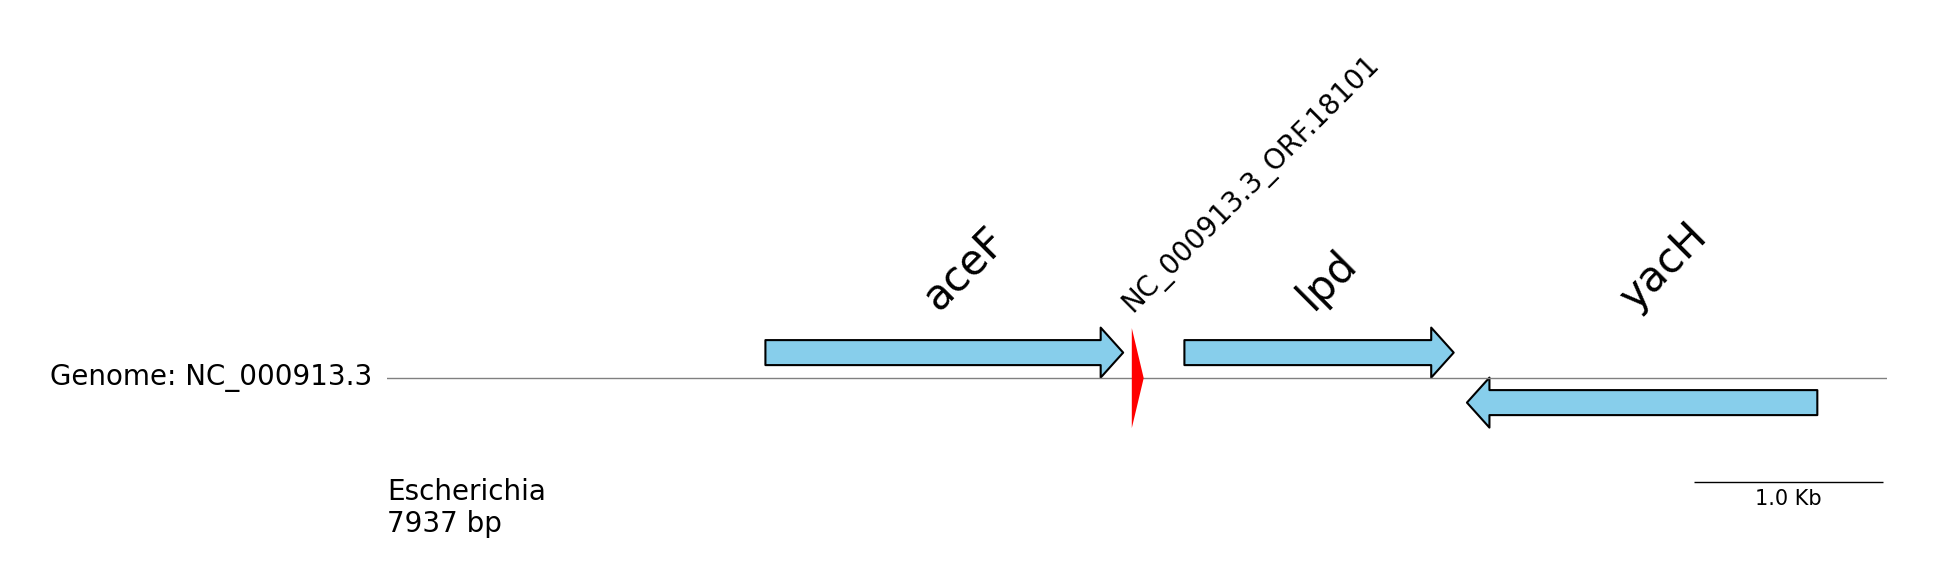

In [14]:
#@title **Geeting information about ismORF (you should know id)**
#@markdown Click in the "Run" button to get info about ismORF
ismORF = "NC_000913.3_ORF.18101" #@param {type:"string"}
#color = "pLDDT" #@param ["pLDDT", "rainbow", "white"]

show_represent_sequences = False #@param {type:"boolean"}
show_genome_region = True #@param {type:"boolean"}
#show_all_sequences = True #@param {type:"boolean"}
ismorf.info = ismORF
ismorf.info
# up and down - range for region
# save  - save image
if show_genome_region:
  ismorf.visualisation(up=4000, down=4000, save=False)
print()
if show_represent_sequences:
  print("Sequences in reference and representative genomes")
  ismorf.fasta()
  print()


Cluster_ID: Escherichia_152423


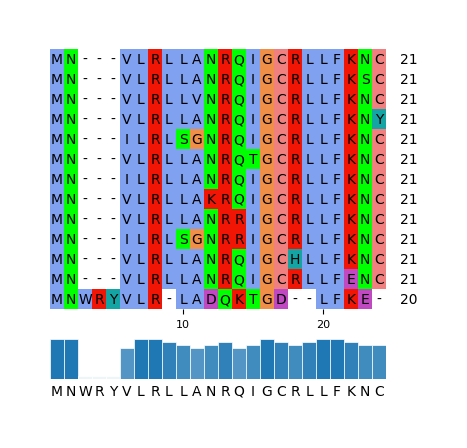

In [15]:
#@title **Nonredundant sequences in the corresponding cluster**
#@markdown Run this cell to look at alignment
cluster_id = ismorf.allfasta()
download_all_sequences_as_fasta = False #@param {type:"boolean"}
#@markdown Use checkbox to save fasta file to your PC
if download_all_sequences_as_fasta:
    res_table = table[table['Cluster_ID']==cluster_id][['Strain', 'id', 'Sequence']]
    with open(f"/content/{cluster_id}.fa", 'w') as outfile:
      for indx, row in res_table.iterrows():
        outfile.write(f">{row['Strain']} {row['id']}\n")
        outfile.write(f"{row['Sequence']}\n")
    files.download(f'/content/{cluster_id}.fa')

In [ ]:
#@title **SEARCH FOR HOMOLOGS AGAINST ENTERO67K**
#@markdown Click "Run" button to load data (This should be done once before search)
%%capture
%%bash
wget -q -o content  ftp.ncbi.nlm.nih.gov/pub/shabalin/small_orf/Entero67K_full.fa.gz
gunzip /content/Entero67K_full.fa.gz
apt install hmmer

In [ ]:
#@markdown Enter sequence and click "Run" button
Sequence = "type sequence here" #@param {type:"string"}
#MFHFYQELSRALAIL
download_table = False #@param {type:"boolean"}
#@markdown Use "download_table" checkbow to save the results to your PC
if Sequence == 'type sequence here':
  pass
else:
  with open('/content/input.fa', 'w') as outfile:
    outfile.write(f">Query\n{Sequence}")

  !jackhmmer -o hmmer.out --tblout /content/hmmer_results.txt -N 3 /content/input.fa /content/Entero67K_full.fa

  '''
  Parsing HMMSEARCH output
  '''

  results = []
  with open ('/content/hmmer_results.txt') as f:
          for line in f:
              if line.startswith('#'):
                  continue

              # Split line into columns
              line_features = line.strip().split(' ')
              line_features = [i for i in line_features if len(i)>0]
              results.append(line_features)

  df = pd.DataFrame(columns=['TargetName','col1','QueryName','col2','E-value',
                           'Score','bias', 'col3','col4','col5','col6','col7',
                           'col8','col9','col10','col11','col12','col13','TargetDescription'], data=results)
  df = df[['TargetName','QueryName','E-value','Score','bias','TargetDescription']]
  df['E-value'] = df['E-value'].astype("float")
  df = df[df['E-value']<0.00001]
  seq_table = table[['id','Sequence']]
  seq_table.rename(columns={"id":"TargetName"}, inplace=True)
  df = df.merge(seq_table, on='TargetName', how='left')
  df['Sequence2'] = Sequence
  df.rename(columns={"Sequence":"ismORF_Sequence", "Sequence2": "Query_Sequence"}, inplace=True)
  print("-"*10)
  if len(df)>0:
    #@markdown Results filtered with E-value < 0.00001
    print(df.head(5))
    print("."*20)
    print("."*20)
    if download_table:
      print("Results saved in SearchHMMER.csv file")
      df.to_csv(f"/content/SearchHMMER.csv", index=False)
      files.download(f'/content/SearchHMMER.csv')
  else:
    print("Possible homologs have not found")

In [ ]:
#@title **Analysis of predicted structures**
#@markdown Run this cell to prepare structures for visualization (This might takes several minutes)

%%capture
!wget -q https://ftp.ncbi.nlm.nih.gov/pub/fesenko/esm_names.csv.gz && gunzip esm_names.csv.gz
!wget -q https://ftp.ncbi.nlm.nih.gov/pub/fesenko/AlphaFoldTable.csv.gz && gunzip AlphaFoldTable.csv.gz
!wget -q https://ftp.ncbi.nlm.nih.gov/pub/fesenko/AF2BEST.tar.gz && tar -xf AF2BEST.tar.gz

!mkdir -p tmp
!pip install py3Dmol

import pandas as pd
import os
import py3Dmol
AF2map = pd.read_csv('AlphaFoldTable.csv', names=['model_id', 'ismORF_ID'], header=0)
ESMmap = pd.read_csv('esm_names.csv', names=['ismORF_ID', 'model_id'], header=0)

In [ ]:
#@title **Enter ismORF id**



ismORF_ID = "NZ_CP043332.1_ORF.30507" #@param {type:"string"}
database = "AlphaFold2" #@param ["AlphaFold2", "ESMfold"]

if database == "AlphaFold2":
  try:
    af2id = AF2map[AF2map.ismORF_ID == ismORF_ID].model_id.values[0]
    pdb_file = 'AF2BEST/' + af2id
  except IndexError:
    try:
      esmid = ESMmap[ESMmap.ismORF_ID == ismORF_ID].model_id.values[0]
      print(f'There is no AF2 model for this ismORF ({ismORF_ID}), loading an ESMfold model')
      os.system(f"wget -O tmp/{esmid}.pdb.gz  https://ftp.ncbi.nlm.nih.gov/pub/fesenko/ESM/{esmid}.pdb.gz ; \
                wget -O tmp/{esmid}.pdb.gz  https://ftp.ncbi.nlm.nih.gov/pub/fesenko/ESM_1/{esmid}.pdb.gz > /dev/null;\
                gunzip tmp/{esmid}.pdb.gz ")
      pdb_file = f'tmp/{esmid}.pdb'
    except IndexError:
      print(f'Cannot find this file, please check if the ({ismORF_ID}) is correct')
      raise
  pass

if database == "ESMfold":
  try:
    esmid = ESMmap[ESMmap.ismORF_ID == ismORF_ID].model_id.values[0]
    os.system(f"wget -O tmp/{esmid}.pdb.gz  https://ftp.ncbi.nlm.nih.gov/pub/fesenko/ESM/{esmid}.pdb.gz ; \
                wget -O tmp/{esmid}.pdb.gz  https://ftp.ncbi.nlm.nih.gov/pub/fesenko/ESM_1/{esmid}.pdb.gz > /dev/null;\
                gunzip tmp/{esmid}.pdb.gz ")
    pdb_file = f'tmp/{esmid}.pdb'

  except IndexError:
    print(f'Cannot find this file, please check if the ({ismORF_ID}) is correct')
    pass


color = "pLDDT" #@param ["pLDDT", "rainbow", "white"]
show_sidechains = True #@param {type:"boolean"}
show_backbone = False #@param {type:"boolean"}

#@markdown Make surface representation
show_surface = False #@param {type:"boolean"}
opacity = 0.81 #@param {type:"slider", min:0.3, max:1, step:0.01}

def show_pdb(rank_num=1, show_sidechains=False, show_backbone=False, color="pLDDT",  opacity=opacity):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(pdb_file,'r').read(), 'pdb')

  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "white":
    view.setStyle({'cartoon': {'color':'white'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_backbone:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_surface:
    view.addSurface(py3Dmol.VDW,{'opacity':opacity,'color':'lightblue'})

  view.zoomTo()
  return view

show_pdb(pdb_file, show_sidechains, show_backbone, color).show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.